# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


In [77]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [3]:
SEED = 42 # seed for random number generation
torch.manual_seed(SEED) # pytorch random generator --> affects model initialization, dropout, etc.
np.random.seed(SEED) # numpy random generator --> affects data shuffling, etc.
random.seed(SEED) # python random generator --> affects data shuffling, etc. (e.g., in sklearn)
torch.use_deterministic_algorithms(True) # ensures that the results are reproducible --> deterministic
torch.backends.cudnn.deterministic = True 


In [4]:
torch.cuda.is_available()

True

In [5]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) # create a fake dataset of 1000 random images
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

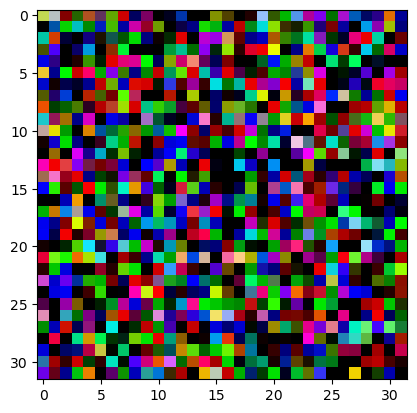

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes #cifar10 classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} #dictionary of class names and their corresponding ids
class_dict #print the class dictionary

In [7]:
x.shape, trainset.classes[y[0]] #print the shape of the first image and its class name

(torch.Size([128, 3, 32, 32]), 'horse')

In [8]:
# A very simple CNN model.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# A very simple CNN model.
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DeepCNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [11]:
device

'cuda'

In [24]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(f"epoch: {e}, loss: {running_loss/len(trainloader):.4f}, lr: {optimizer.param_groups[0]['lr']}")
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')      

epoch: 0, loss: 1.7942, lr: 0.0001
epoch: 1, loss: 1.4718, lr: 0.0001
epoch: 2, loss: 1.3393, lr: 0.0001
epoch: 3, loss: 1.2538, lr: 0.0001
epoch: 4, loss: 1.1701, lr: 0.0001
epoch: 5, loss: 1.1007, lr: 0.0001
epoch: 6, loss: 1.0298, lr: 0.0001
epoch: 7, loss: 0.9654, lr: 0.0001
epoch: 8, loss: 0.8912, lr: 0.0001
epoch: 9, loss: 0.8246, lr: 0.0001
epoch: 10, loss: 0.7588, lr: 0.0001
epoch: 11, loss: 0.6876, lr: 0.0001
epoch: 12, loss: 0.6141, lr: 0.0001
epoch: 13, loss: 0.5411, lr: 0.0001
epoch: 14, loss: 0.4715, lr: 0.0001
epoch: 15, loss: 0.3946, lr: 0.0001
epoch: 16, loss: 0.3279, lr: 0.0001
epoch: 17, loss: 0.2557, lr: 0.0001
epoch: 18, loss: 0.1916, lr: 0.0001
epoch: 19, loss: 0.1418, lr: 0.0001
epoch: 20, loss: 0.1036, lr: 0.0001
epoch: 21, loss: 0.0782, lr: 0.0001
epoch: 22, loss: 0.0661, lr: 0.0001
epoch: 23, loss: 0.0647, lr: 0.0001
epoch: 24, loss: 0.0566, lr: 0.0001
epoch: 25, loss: 0.0492, lr: 0.0001
epoch: 26, loss: 0.0388, lr: 0.0001
epoch: 27, loss: 0.0410, lr: 0.0001
ep

In [ ]:
if load:
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth'))
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

/tmp/ipykernel_4513/828887696.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./cifar10_CNN_50_0.0001.pth')) #fully trained


Accuracy: 0.6686999797821045


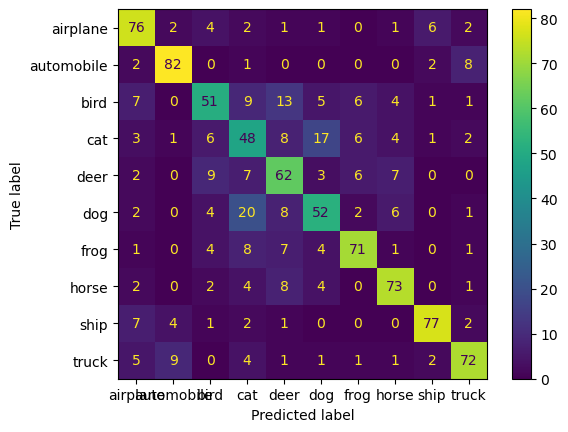

Per class accuracy: 0.6687


In [85]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
load = True
if load:
    model = DeepCNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN_50_0.0001.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

In [ ]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

In [12]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)
        

Accuracy: 0.6686999797821045


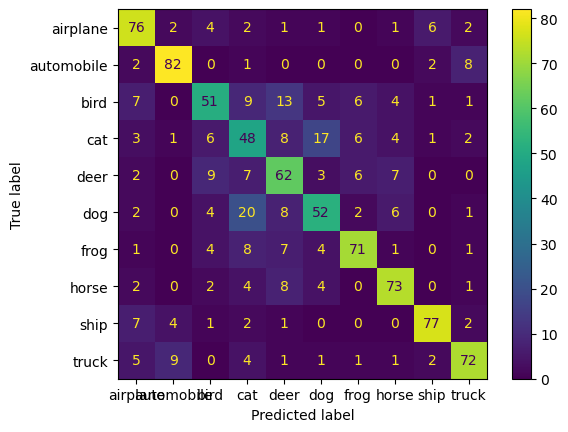

In [13]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()


In [16]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


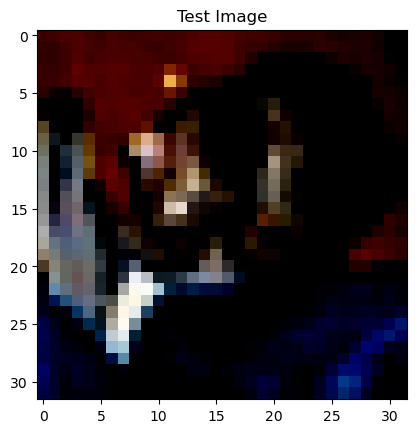

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


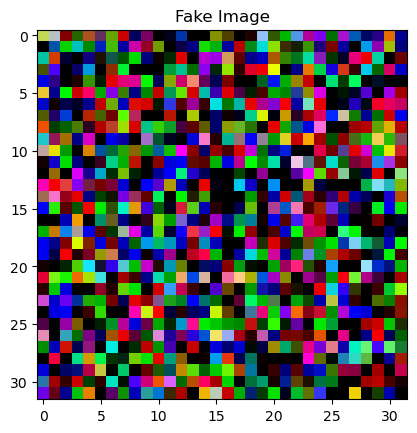

'for data in fakeloader:\n    xfake, _ = data\n    plt.imshow(x[0,:].permute(1,2,0))\n    break'

In [14]:
for data in testloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    plt.title('Test Image')
    plt.show()
    break

for data in fakeloader:
    xfake, _ = data
    plt.imshow(xfake[0,:].permute(1,2,0))  # Usa xfake invece di x
    plt.title('Fake Image') 
    plt.show()
    break

"""for data in fakeloader:
    xfake, _ = data
    plt.imshow(x[0,:].permute(1,2,0))
    break"""



GT: 9, truck


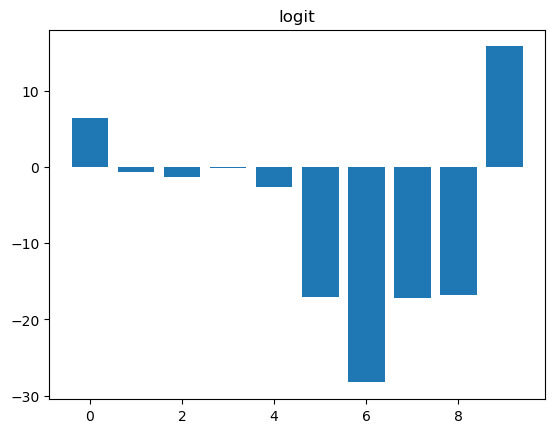

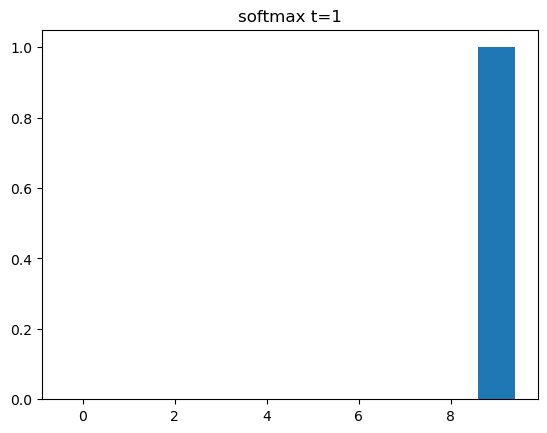

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


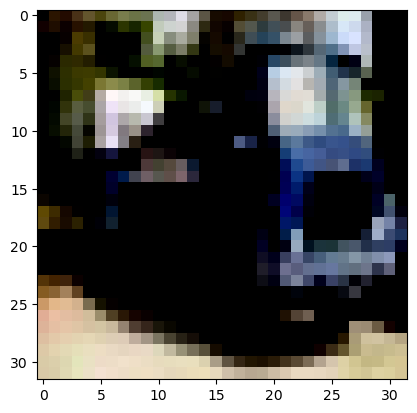

In [15]:
import random
#Example of logit and softmax output with real data
#k=0#the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label --> select a random sample from the batch
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 #Temperature for the softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.title(f'softmax t={T}')
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()


    

In [21]:
x.shape

torch.Size([128, 3, 32, 32])

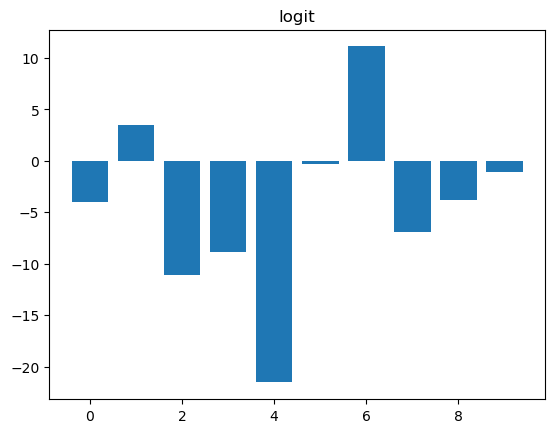

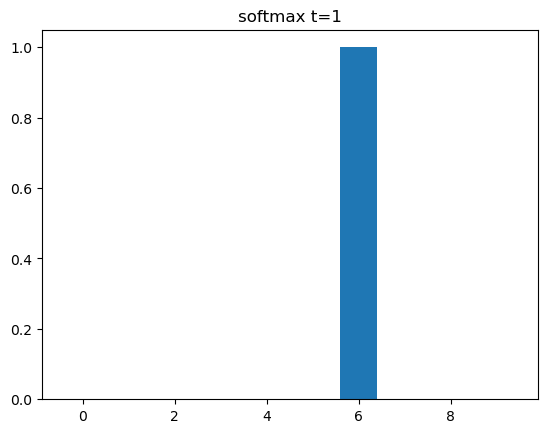

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


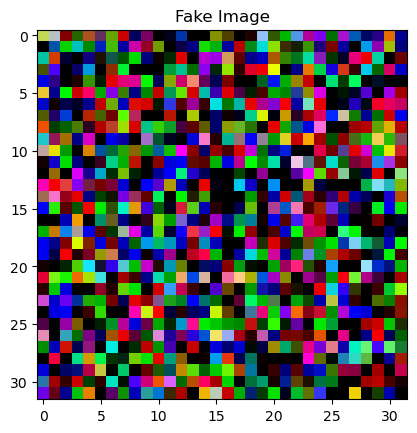

In [16]:
#Example of logit and softmax output with fake data
k=0
output = model(xfake.cuda()) #the kth sample of the batch (fake data)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0)) #fake image has no label
plt.title('Fake Image')
plt.show()


    

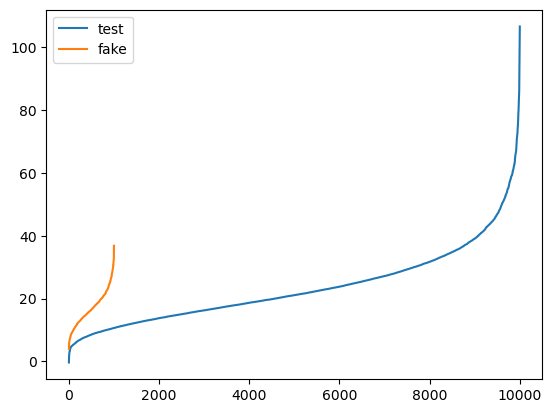

In [17]:
# ood detection with max logit/max softmax scores
# thw model should be more "confident" on in-distribution data than on OOD data
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()



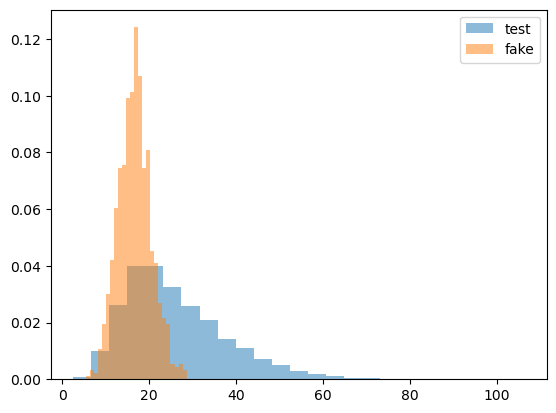

In [ ]:
# x --> scores, y --> probability density, alpha --> transparency
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [19]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss() # difference between the input and the output of the autoencoder (the reconstructed version of the input)
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [15]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(f"epoch: {e}, loss: {running_loss/len(trainloader):.4f}, lr: {optimizer.param_groups[0]['lr']}")
    

epoch: 0, loss: 0.3002, lr: 0.0001
epoch: 1, loss: 0.2040, lr: 0.0001
epoch: 2, loss: 0.1924, lr: 0.0001
epoch: 3, loss: 0.1855, lr: 0.0001
epoch: 4, loss: 0.1801, lr: 0.0001
epoch: 5, loss: 0.1772, lr: 0.0001
epoch: 6, loss: 0.1754, lr: 0.0001
epoch: 7, loss: 0.1728, lr: 0.0001
epoch: 8, loss: 0.1671, lr: 0.0001
epoch: 9, loss: 0.1642, lr: 0.0001
epoch: 10, loss: 0.1611, lr: 0.0001
epoch: 11, loss: 0.1592, lr: 0.0001
epoch: 12, loss: 0.1581, lr: 0.0001
epoch: 13, loss: 0.1572, lr: 0.0001
epoch: 14, loss: 0.1565, lr: 0.0001
epoch: 15, loss: 0.1558, lr: 0.0001
epoch: 16, loss: 0.1552, lr: 0.0001
epoch: 17, loss: 0.1546, lr: 0.0001
epoch: 18, loss: 0.1540, lr: 0.0001
epoch: 19, loss: 0.1535, lr: 0.0001


In [ ]:
model_ae.eval()
#use negative MSE since higher error means OOD --> higher score for OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x) #z --> encoded version, xr --> reconstructed version
        l = loss(x, xr)
        score = l.mean([1,2,3]) # mean over channels and spatial dimensions
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)



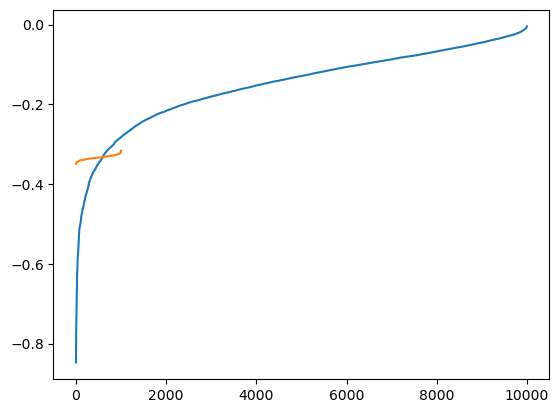

In [ ]:
plt.plot(sorted(scores_test_ae.cpu())) # x--> samples sorted by score, y --> score
plt.plot(sorted(scores_fake_ae.cpu()))


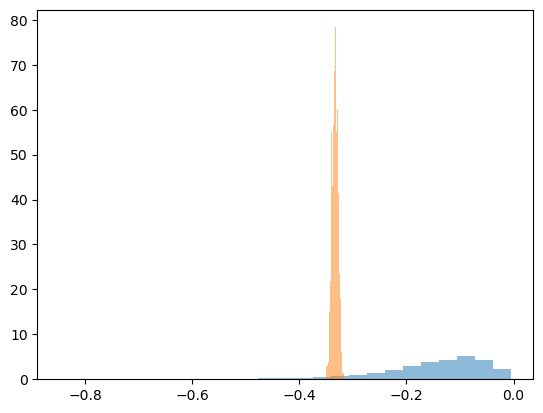

In [19]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



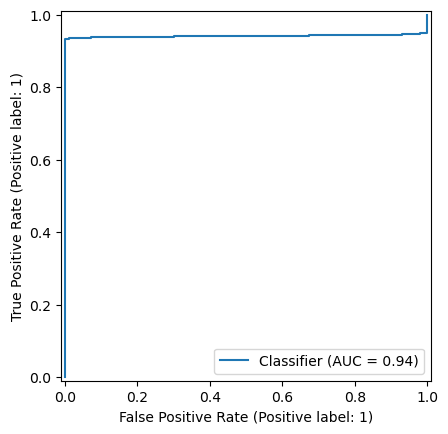

In [20]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

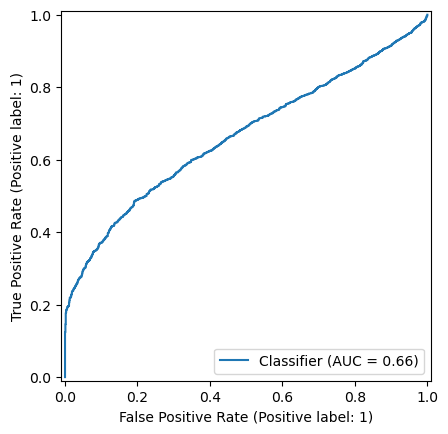

In [29]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [37]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [31]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


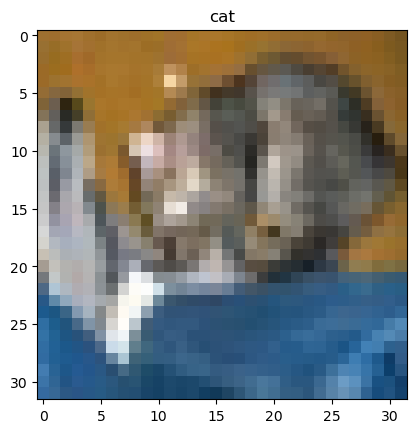

Attack!!
target: deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.056862637..1.0058825].


3 3
3 3
4 3
Targeted attack(deer) success! budget:3/255


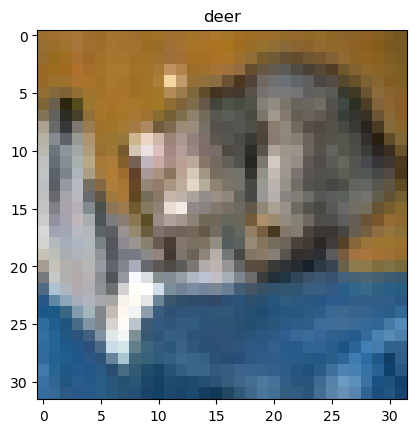

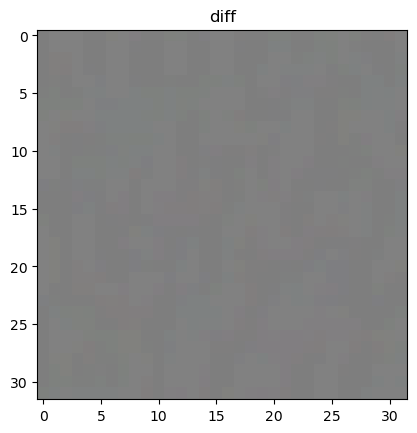

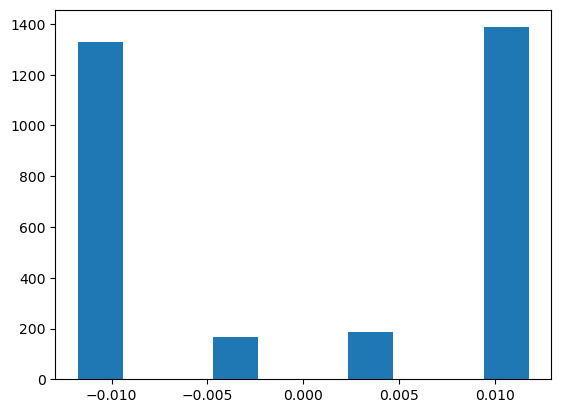

In [ ]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer'] # target class for targeted attack
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone() # save the original image to compute the difference later
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted, we want the model to predict the target class
        else:
            yt=y #untargeted, we want the model to misclassify the original class
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted, minimize the loss w.r.t. the target class
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted, maximize the loss w.r.t. the original class
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            #success if  the predicted class is different from the original class
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            #success if the predicted class is the target class
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())
    






In [33]:
x.shape

torch.Size([1, 3, 32, 32])

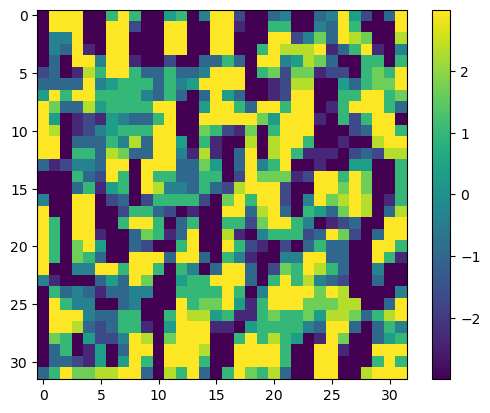

In [34]:
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [31]:
# Your code here.
def fgsm(model, x, y, eps, targeted=False, target_class=None):
    x_perturbed = x.clone().detach().requires_grad_(True)
    output = model(x_perturbed)
    if targeted and target_class is not None:
        loss_fn = nn.CrossEntropyLoss()
        target = torch.full_like(y, target_class)
    else:
        target = y
    
    loss = F.cross_entropy(output, target)
    loss.backward()

    with torch.no_grad():
        if targeted:
            perturbed = x_perturbed - eps * torch.sign(x_perturbed.grad)
        else:
            perturbed = x_perturbed + eps * torch.sign(x_perturbed.grad)
    return perturbed

In [90]:
model_adv_aug = DeepCNN().to(device)
# Training loop con augmentation
model_adv_aug.train()
epochs = 50
eps = 1/255  # budget per FGSM

for epoch in range(epochs):
    running_loss = 0
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        # Genera versione avversaria di metà batch
        batch_size = x.shape[0]
        split = batch_size // 2
        x_clean = x[:split]
        x_adv = fgsm(model, x[split:], y[split:], eps)
        
        # Concatena clean e adversarial
        x_combined = torch.cat([x_clean, x_adv])
        y_combined = y  # le label rimangono le stesse
        
        # Forward e backward normali
        optimizer.zero_grad()
        output = model(x_combined)
        l = loss(output, y_combined)
        l.backward()
        optimizer.step()
        
        running_loss += l.item()
        
    print(f"epoch: {epoch}, loss: {running_loss/len(trainloader):.4f}")

epoch: 0, loss: 0.0536
epoch: 1, loss: 0.0538
epoch: 2, loss: 0.0523
epoch: 3, loss: 0.0527
epoch: 4, loss: 0.0524
epoch: 5, loss: 0.0532
epoch: 6, loss: 0.0534
epoch: 7, loss: 0.0549
epoch: 8, loss: 0.0532
epoch: 9, loss: 0.0519
epoch: 10, loss: 0.0520
epoch: 11, loss: 0.0531
epoch: 12, loss: 0.0542
epoch: 13, loss: 0.0532
epoch: 14, loss: 0.0533
epoch: 15, loss: 0.0526
epoch: 16, loss: 0.0525
epoch: 17, loss: 0.0535
epoch: 18, loss: 0.0523
epoch: 19, loss: 0.0520
epoch: 20, loss: 0.0531
epoch: 21, loss: 0.0529
epoch: 22, loss: 0.0532
epoch: 23, loss: 0.0532
epoch: 24, loss: 0.0523
epoch: 25, loss: 0.0528
epoch: 26, loss: 0.0522
epoch: 27, loss: 0.0531
epoch: 28, loss: 0.0524
epoch: 29, loss: 0.0527
epoch: 30, loss: 0.0538
epoch: 31, loss: 0.0533
epoch: 32, loss: 0.0534
epoch: 33, loss: 0.0525
epoch: 34, loss: 0.0516
epoch: 35, loss: 0.0531
epoch: 36, loss: 0.0519
epoch: 37, loss: 0.0548
epoch: 38, loss: 0.0525
epoch: 39, loss: 0.0533
epoch: 40, loss: 0.0530
epoch: 41, loss: 0.0508
ep

GT: 9, truck


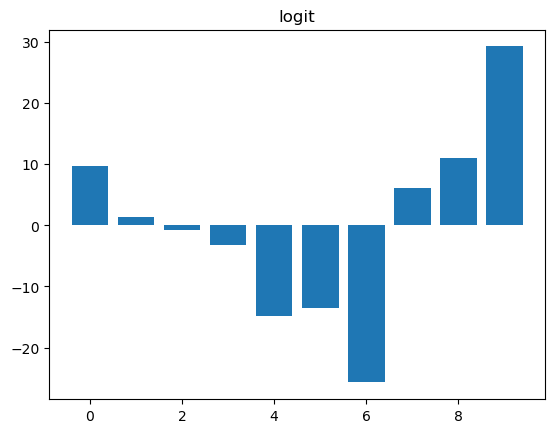

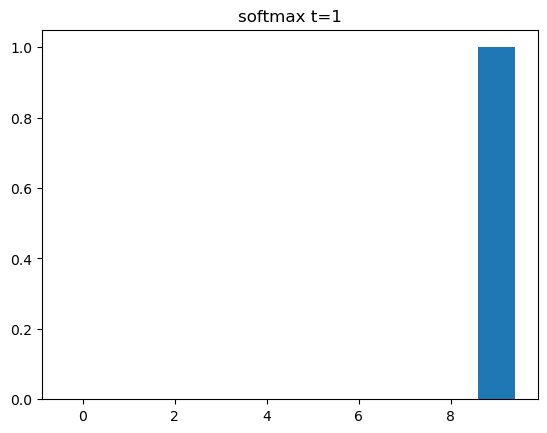

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].


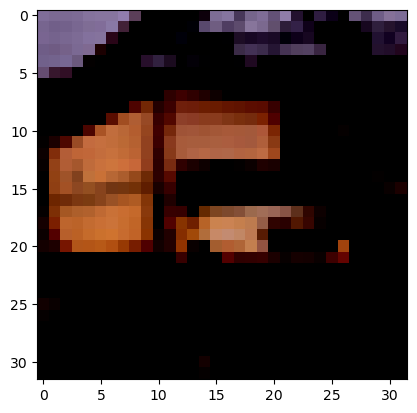

In [27]:
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label --> select a random sample from the batch
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 #Temperature for the softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.title(f'softmax t={T}')
plt.show()

plt.imshow(x[k,:].cpu().permute(1,2,0))
plt.show()

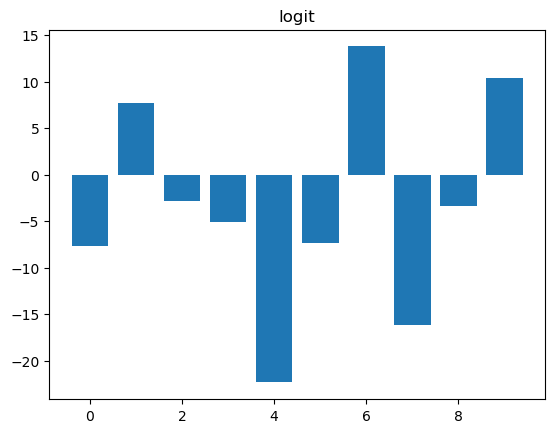

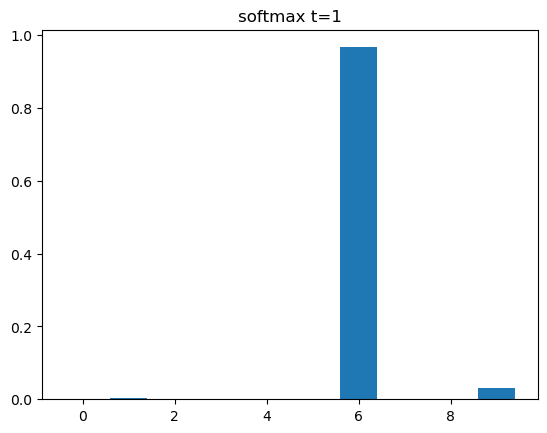

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


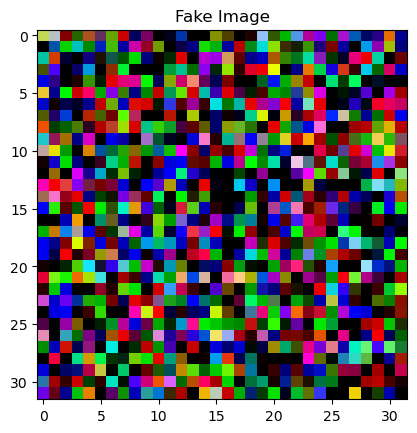

In [28]:
#Example of logit and softmax output with fake data
k=2
output = model(xfake.cuda()) #the kth sample of the batch (fake data)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0)) #fake image has no label
plt.title('Fake Image')
plt.show()


    

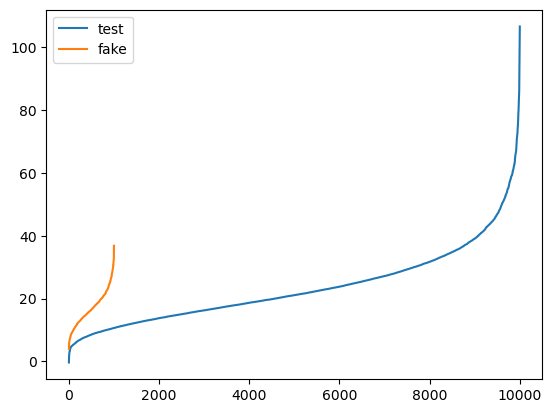

In [29]:
scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()

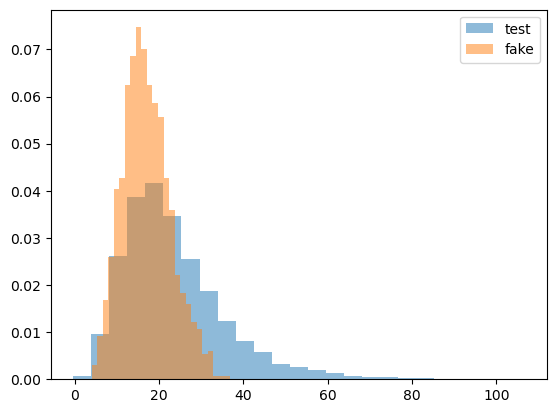

In [30]:
# x --> scores, y --> probability density, alpha --> transparency
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


FGSM augmentation can reduce OOD detection robustness due to three main factors: 
(1) it may induce overconfidence on spurious patterns, as adversarial examples seen during training remain close to the original distribution; 
(2) adversarial training tends to overly smooth decision boundaries, making the model assign high confidence even to truly OOD samples;
(3) while it improves robustness to attacks, it often worsens calibration, reducing the reliability of confidence estimates for OOD detection.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


Exercise 3.1

In [83]:
# funzione softmax con temperatura
def softmax_with_temp(logits, T=1.0):
    return F.softmax(logits / T, dim=1)

# step di perturbazione ODIN
def perturb_input(model, x, T=1.0, epsilon=0.001):
    x.requires_grad = True
    logits = model(x)
    pred = softmax_with_temp(logits, T)
    # prendiamo la classe più probabile
    label = pred.max(1)[1]
    loss = F.cross_entropy(logits / T, label)
    loss.backward()
    # perturbazione segno del gradiente
    delta = epsilon * x.grad.data.sign()
    x_perturbed = x.data - delta
    return x_perturbed

# funzione per calcolare i punteggi ODIN (confidence score)
def odin_score(model, x, T=1.0, epsilon=0.001):
    x_pert = perturb_input(model, x, T, epsilon)
    logits = model(x_pert)
    probs = softmax_with_temp(logits, T)
    conf, _ = probs.max(1)
    return conf.detach().cpu().numpy()


In [ ]:
from tqdm import tqdm
temperatures = [1, 10, 100]
epsilons = [0.0, 0.001, 0.002, 0.004]

transform = transforms.Compose([
    transforms.ToTensor(),
])

# ID = CIFAR10 testloader (già ce l’hai)
id_loader = testloader

# OOD = SVHN test set
ood_dataset = datasets.SVHN(root="./data", split="test", download=True, transform=transform)
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=64, shuffle=False)
results = {}

for T in temperatures:
    for eps in epsilons:
        id_scores, ood_scores = [], []

        for x, _ in tqdm(id_loader, desc=f"T={T}, eps={eps}, ID"):
            x = x.cuda()
            scores = odin_score(model, x, T, eps)
            id_scores.extend(scores)

        for x, _ in tqdm(ood_loader, desc=f"T={T}, eps={eps}, OOD"):
            x = x.cuda()
            scores = odin_score(model, x, T, eps)
            ood_scores.extend(scores)

        # esempio: AUROC (usando scikit-learn)
        from sklearn.metrics import roc_auc_score
        y_true = np.array([1]*len(id_scores) + [0]*len(ood_scores))
        y_score = np.array(id_scores + ood_scores)
        auroc = roc_auc_score(y_true, y_score)
        
        results[(T, eps)] = auroc

# migliori iperparametri
best = max(results, key=results.get)
print("Migliori T, eps:", best, "AUROC:", results[best])


Using downloaded and verified file: ./data/test_32x32.mat


T=100, eps=0.004, OOD: 100%|██████████| 407/407 [00:17<00:00, 22.90it/s]

Migliori T, eps: (10, 0.004) AUROC: 0.9114402504609712


In [93]:
def plot_scores(id_scores, ood_scores, best):
    best_T, best_eps = best
    plt.figure(figsize=(8,5))
    plt.hist(id_scores, bins=50, alpha=0.6, label="In-Distribution (CIFAR10)", density=True)
    plt.hist(ood_scores, bins=50, alpha=0.6, label="Out-of-Distribution", density=True)
    plt.xlabel("ODIN confidence score")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"ODIN scores - T={best_T}, ε={best_eps}")
    plt.show()

In [91]:
results2 = {}
for T in temperatures:
    for eps in epsilons:
        id_scores2, ood_scores2 = [], []

        for x, _ in tqdm(id_loader, desc=f"T={T}, eps={eps}, ID"):
            x = x.cuda()
            scores = odin_score(model_adv_aug, x, T, eps)
            id_scores2.extend(scores)

        for x, _ in tqdm(ood_loader, desc=f"T={T}, eps={eps}, OOD"):
            x = x.cuda()
            scores = odin_score(model_adv_aug, x, T, eps)
            ood_scores2.extend(scores)

        # esempio: AUROC (usando scikit-learn)
        from sklearn.metrics import roc_auc_score
        y_true = np.array([1]*len(id_scores2) + [0]*len(ood_scores2))
        y_score = np.array(id_scores2 + ood_scores2)
        auroc = roc_auc_score(y_true, y_score)
        
        results2[(T, eps)] = auroc

# migliori iperparametri
best2 = max(results, key=results.get)
print("Migliori T, eps:", best, "AUROC:", results2[best2])

T=100, eps=0.004, OOD: 100%|██████████| 407/407 [00:17<00:00, 23.65it/s]

Migliori T, eps: (10, 0.004) AUROC: 0.5428877170405655


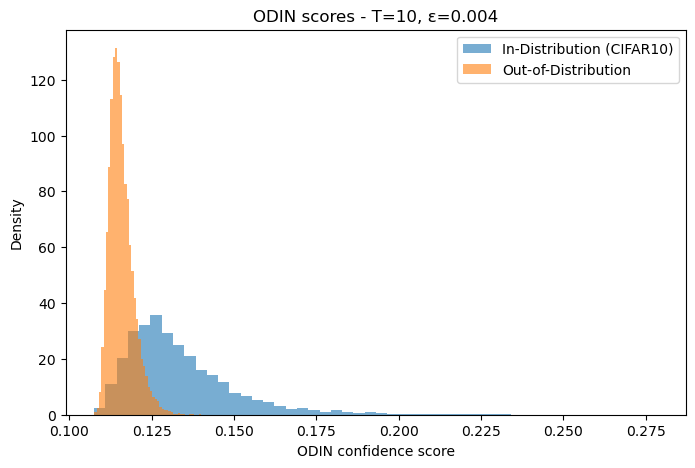

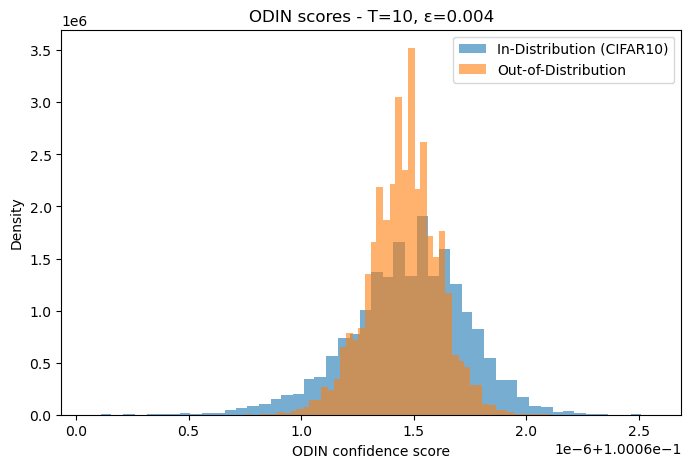

In [ ]:
print("Standard trained model:")
plot_scores(id_scores, ood_scores, best)
print("Adversarially trained model:")
plot_scores(id_scores2, ood_scores2, best2)